In [1]:
from fastai.vision import *

# Get a list of URLs 

### First Search and scroll

Go to images.google.com and search for the required images.
Scroll down till you find enough images.


### Download into file

   ##### Run this script after clicking ctrl+j in chrome browser
        urls=Array.from(document.querySelectorAll('.rg_i')).map(el=>el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
        window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));


# Create directory and upload urls file into your server

In [43]:
folder = 'Black'
file = 'urls_black.csv'

In [45]:
folder = 'Teddys'
file = 'urls_teddy.csv'

In [49]:
folder = 'Grizzly'
file = 'urls_grizzly.csv'

Run this cell once per each category

In [50]:
path = Path('C:\\Users\\humai\\.fastai\\data\\bear')
dest = path/folder
dest.mkdir(parents = True,exist_ok = True)

In [51]:
path.ls()
dest

WindowsPath('C:/Users/humai/.fastai/data/bear/Grizzly')

# Download Images

    Now download the images from the respective URLs.
    In FastAI we have a function that does this job for us.
    We have to pass the *URLs* and the *DESTINATION*
    Only the images that can be downloaded

In [52]:
classes = ['Teddys','Grizzly','Black']

In [53]:
download_images(path/file, dest, max_pics=200)

Once all the folders are done, we can remove the images that cant be opened

In [55]:
for c in classes:
    print(c)
    verify_images(path/c,delete=True,max_size=500)

Teddys


Grizzly


Black


# View Data

In [3]:
np.random.seed(42) #To get the same data everytime we run the cell
data = ImageDataBunch.from_folder(path,train = ".",valid_pct = 0.2,
                                 ds_tfms =get_transforms(),size = 224,num_workers=4).normalize(imagenet_stats)

In [4]:
data.classes

['Black', 'Grizzly', 'Teddys']

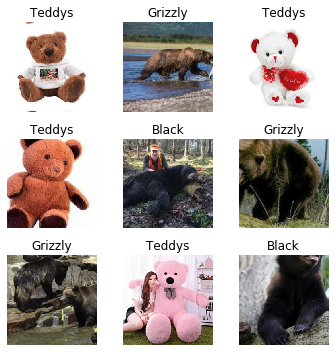

In [5]:
data.show_batch(rows = 3,figsize= (5,5))

In [6]:
data.classes,data.c,len(data.train_ds),len(data.valid_ds)

(['Black', 'Grizzly', 'Teddys'], 3, 380, 95)

# Train model

In [7]:
learn = cnn_learner(data,models.resnet34,metrics = error_rate)

In [8]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.239435,0.078962,0.042105,00:54
1,0.684326,0.052056,0.010526,00:29
2,0.482802,0.062904,0.021053,00:29
3,0.360733,0.066193,0.021053,00:29


In [9]:
learn.save('stage-1')

In [10]:
learn.unfreeze()

In [13]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


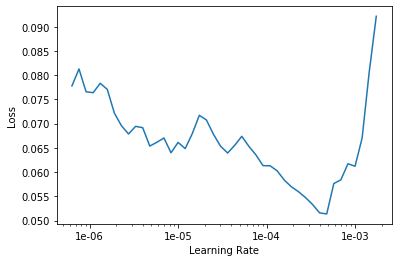

In [14]:
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(1,max_lr=slice(1e-04,1e-03))

epoch,train_loss,valid_loss,error_rate,time
0,0.304365,0.768792,0.157895,00:32


### CIRCLE OF THUMB


    10 times less than your first part
    learn.fit_one_cycle(epochs,max_lr=slice(*what you get from lr_finder()*,3e-4))
        Here .0003 and so on

In [16]:
#Since the error_rate is comparatively high we roll back to the checkpoint
learn.save('stage-2')
learn.load('stage-2');

# Interpretation

In [76]:
interp = ClassificationInterpretation.from_learner(learn)

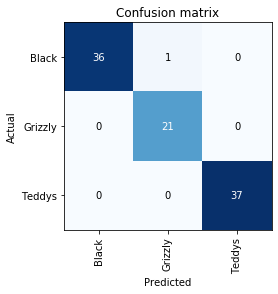

In [77]:
interp.plot_confusion_matrix()

# Cleaning Up

In [92]:
from fastai.widgets import *

ds,idxs = DatasetFormatter().from_toplosses(learn)
#DatasetFormatter combined with from_toplosses() returns a dataset with the most 
#problematic images from the learner

In [96]:
ds

LabelList (380 items)
x: ImageList
Image (3, 250, 300),Image (3, 250, 300),Image (3, 250, 300),Image (3, 250, 300),Image (3, 250, 300)
y: CategoryList
Black,Black,Black,Black,Black
Path: C:\Users\humai\.fastai\data\bear

In [85]:
ImageCleaner??

Init signature:
ImageCleaner(
    dataset: fastai.data_block.LabelLists,
    fns_idxs: Collection[int],
    path: Union[pathlib.Path, str],
    batch_size=5,
    duplicates=False,
)
Source:        
class ImageCleaner(BasicImageWidget):
    "Displays images for relabeling or deletion and saves changes in `path` as 'cleaned.csv'."
    def __init__(self, dataset:LabelLists, fns_idxs:Collection[int], path:PathOrStr, batch_size=5, duplicates=False):
        super().__init__(dataset, fns_idxs, batch_size=(2 if duplicates else batch_size),
                         drop_batch_on_nonfile=duplicates, before_next_batch=self.before_next_batch)
        self._duplicates,self._path,self._skipped = duplicates,Path(path),0
        self._csv_dict = {dataset.x.items[i]: dataset.y[i] for i in range(len(dataset))}
        self._deleted_fns:List[Path] = []
        self.next_batch()

    def make_payload(self, idx:int): return {'file_path': self._dataset.x.items[idx]}

    def before_next_batch(self, payload

In [97]:
ImageCleaner(ds,idxs,path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

    ImageCleaner doesnt clean anything on disk.
    It creates a 'cleaned.csv' and stores it in your data path.
    Now load new databunch for the files to changes to be applied

In [98]:
df = pd.read_csv(path/'cleaned.csv',header='infer')

In [99]:
df

,name,label
0,Black\00000022.jpg,Black
1,Black\00000023.jpg,Black
2,Black\00000024.jpg,Black
3,Black\00000025.jpg,Black
4,Black\00000026.jpg,Black
...,...,...
375,Teddys\00000192.jpg,Teddys
376,Teddys\00000196.jpg,Teddys
377,Teddys\00000197.jpg,Teddys
378,Teddys\00000198.jpg,Teddys


In [104]:
# We create a databunch from our csv. We include the data in the training set and we don't use a validation set (DatasetFormatter uses only the training set)
np.random.seed(42)
db = (ImageList.from_df(df,path)
     .split_none()
     .label_from_df()
     .databunch(bs=64,no_check=True)
     )

In [105]:
db

ImageDataBunch;

Train: LabelList (380 items)
x: ImageList
Image (3, 213, 237),Image (3, 203, 249),Image (3, 188, 269),Image (3, 271, 186),Image (3, 275, 183)
y: CategoryList
Black,Black,Black,Black,Black
Path: C:\Users\humai\.fastai\data\bear;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: C:\Users\humai\.fastai\data\bear;

Test: None

In [106]:
learn_clean = cnn_learner(db,models.resnet34,metrics = error_rate)

NOTE
* Since there is no images removed I am not proceeding with the previous learn
* and not calculating lr_finder() and recording the plot and unfreezing it and saving it

# Putting your model in production

In [17]:
learn.export()

* NOTE
    * This will create a file named 'export.pkl' in the directory
    * It'll contain the model, the weights and some metadata.
    * For inferemce use CPU

In [26]:
#defaults.device = torch.device('cpu')
#while deploying as an application uncomment this

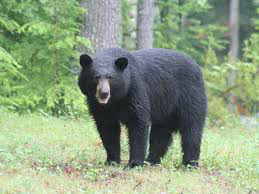

In [30]:
img = open_image(path/'black'/'00000021.jpg')
img

In [31]:
learn = load_learner(path)

In [32]:
pred_class,pred_idx,outputs = learn.predict(img)

In [33]:
pred_class

Category Black

We can create an appliction using this

```python
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })
```